<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/SDXL/SDXL_IP_Adatper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tencents IP-Adapter for SDXL. The last two code cells can each be re-run, one uses just the image prompt, the other uses a mix of image and text prompts.  

This example uses the test images from the Tencent git repository

At this point in time Diffusers doesn't have IP Adapter support built in (there's a Pull Request, but it isn't merged). There may be a better way to do this by the time you're reading this comment.


In [3]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy
! git clone https://github.com/tencent-ailab/IP-Adapter.git
! wget -c https://huggingface.co/InvokeAI/ip_adapter_sdxl/resolve/main/ip_adapter.bin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.8 MB/s eta 0:00:00
Cloning into 'IP-Adapter'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 288 (delta 86), reused 77 (delta 58), pack-reused 164
Receiving objects: 100% (288/288), 69.44 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (143/143), done.
--2023-11-04 11:

In [4]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
from PIL import Image
import sys
import gc
import random
import mediapy


sys.path.insert(0,'/content/IP-Adapter')

from ip_adapter import  IPAdapterXL

base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "InvokeAI/ip_adapter_sdxl_image_encoder"
ip_ckpt = "ip_adapter.bin"
device = "cuda"


vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to(device)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    variant='fp16',
    add_watermarker=False,
    vae=vae
)

pipe.to(device)
pipe.enable_vae_tiling()
pipe.enable_vae_slicing()

ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The cell below is a re-runable cell that uses the image as the only prompt


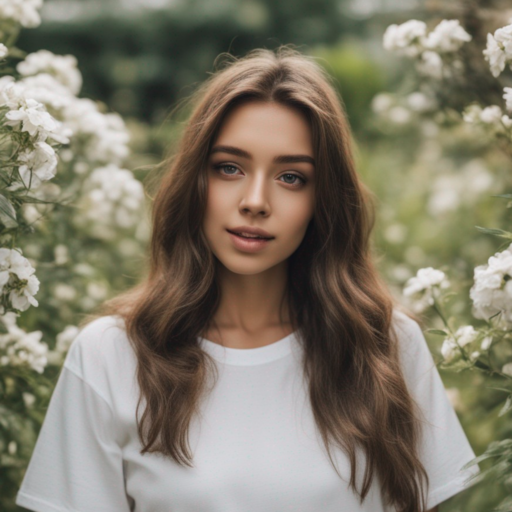

  0%|          | 0/30 [00:00<?, ?it/s]


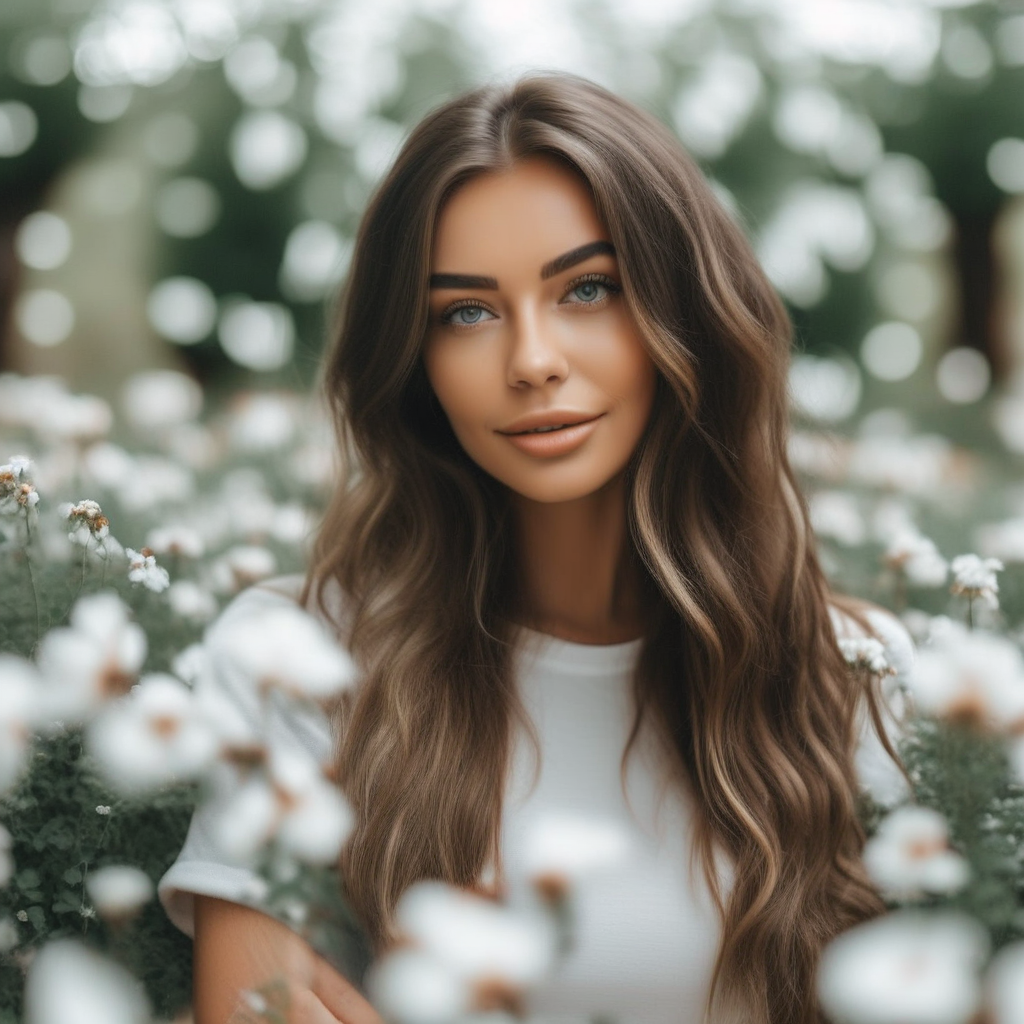
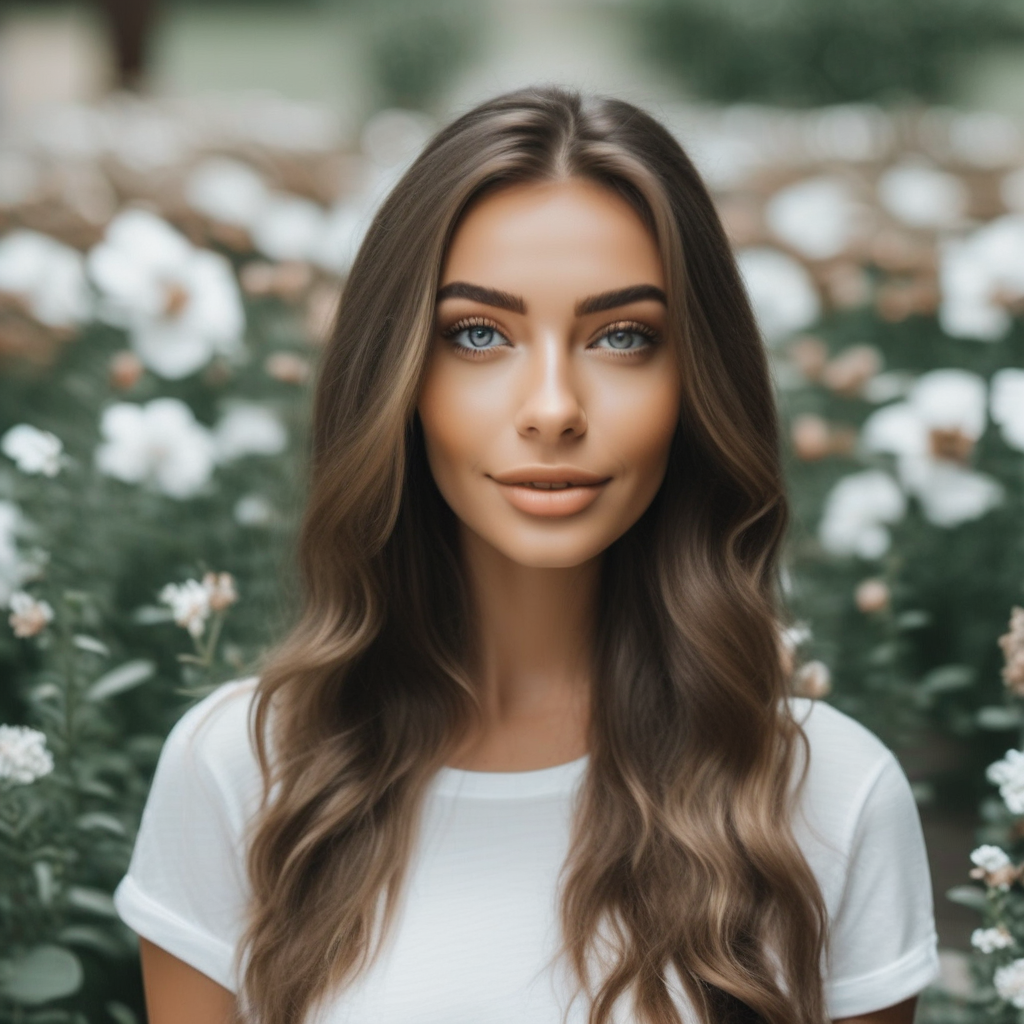

In [14]:
image = Image.open("/content/IP-Adapter/assets/images/girl.png")
output_image_count = 2
seed = random.randint(0, sys.maxsize)

mediapy.show_image(image)

grid = None
images = None
gc.collect()
torch.cuda.empty_cache()


# generate image variations with only image prompt
images = ip_model.generate(pil_image=image, num_samples=output_image_count, num_inference_steps=30, seed=seed)
mediapy.show_images(images, columns=1)


The next cell is a re-runable cell the uses the image along side a text prompt (an optional negative text prompt)


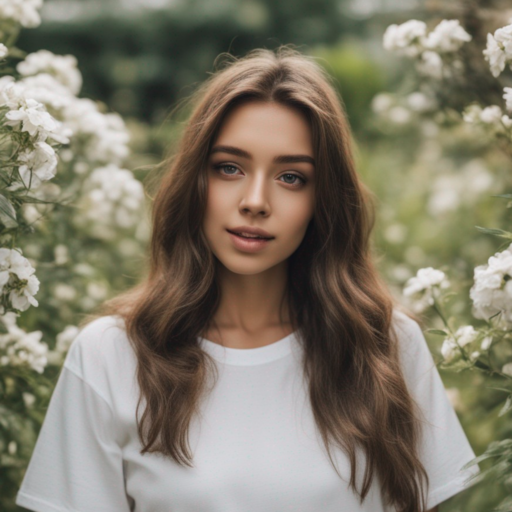

  0%|          | 0/30 [00:00<?, ?it/s]


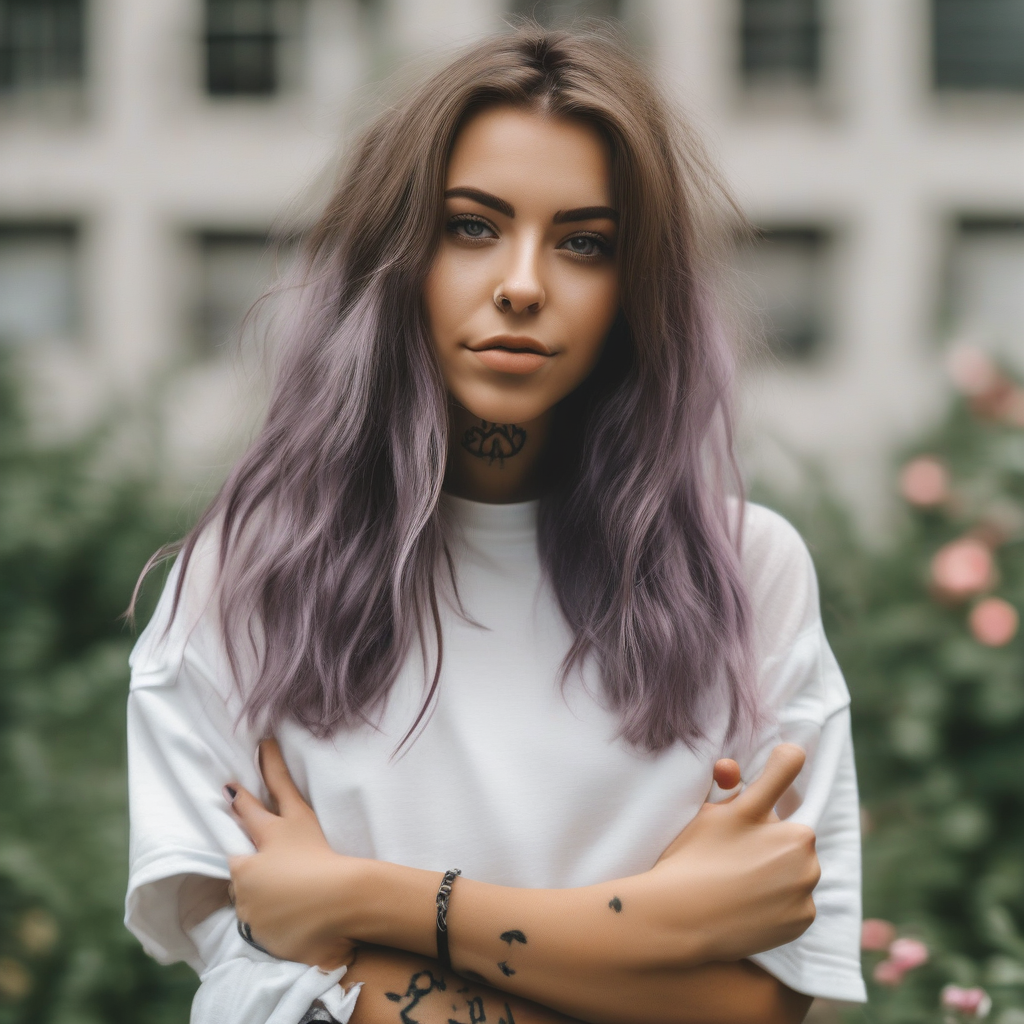
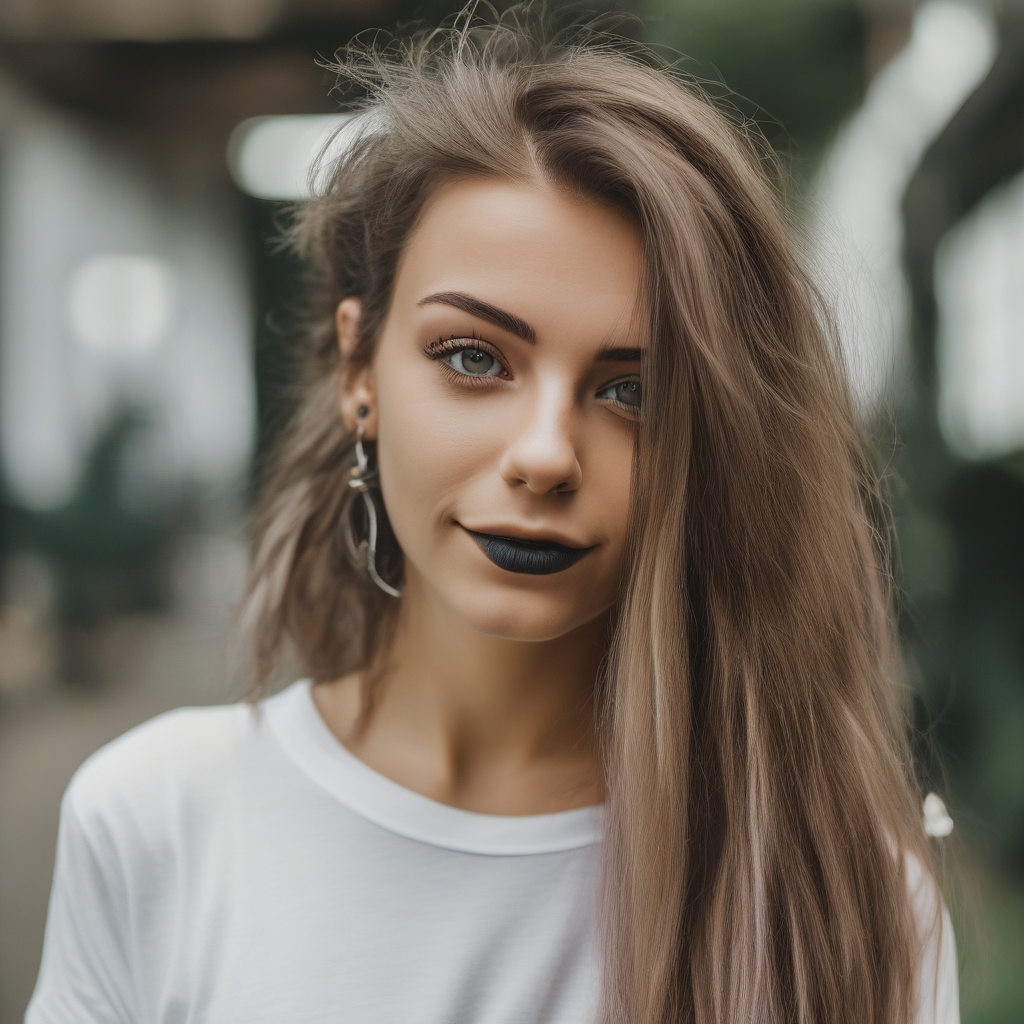

In [15]:
image = Image.open("/content/IP-Adapter/assets/images/girl.png")
prompt="a punk rocker with purple hair and nose piercings"
negative_prompt = ""
output_image_count = 2
seed = random.randint(0, sys.maxsize)

mediapy.show_image(image)

grid = None
images = None

gc.collect()
torch.cuda.empty_cache()


images = ip_model.generate(pil_image=image, num_samples=output_image_count, num_inference_steps=30, seed=seed,
        prompt=prompt, negative_prompt=negative_prompt, scale=0.5)
mediapy.show_images(images, columns=1)
